# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def print3D(x, y, z=None, c='b'):
    if z is None:
        plt.scatter(x,y, c=c)
    else:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(x, y, z, c=c)

**Сгенирирум данные**

In [4]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

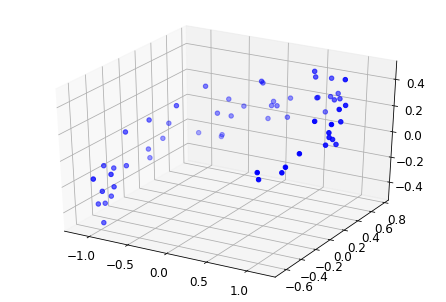

In [5]:
print3D(X[:, 0], X[:, 1], X[:, 2])

# PCA

### PCA using Numpy

In [6]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
print(Vt.T[:, 0]) #c1
print(Vt.T[:, 1]) #c2

[0.93636116 0.29854881 0.18465208]
[-0.34027485  0.90119108  0.2684542 ]


Восстановим набор данных, используя матричные умножения, и сравним с исходным

In [7]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)
x_svd_rec = np.matmul(U, S)
x_svd_rec = np.matmul(x_svd_rec, Vt)
np.allclose(X_centered, x_svd_rec)

True

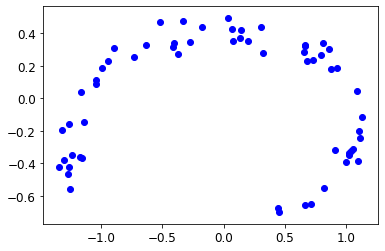

In [8]:
W2 = Vt[:2].T
X2D_svd = np.matmul(X_centered, W2)
print3D(X2D_svd[:, 0], X2D_svd[:, 1])

## PCA in SKLean

pca principal components:
 [[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]

principal components calculated manually:
 [[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]

PC components at both examples the same?
 True


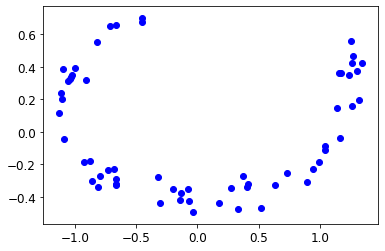

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D_sk = pca.fit_transform(X)
print3D(X2D_sk[:, 0], X2D_sk[:, 1])

print("pca principal components:\n", pca.components_)
print("\nprincipal components calculated manually:\n", W2.T)
print("\nPC components at both examples the same?\n", np.allclose(-pca.components_, W2.T))

Визуально результат такой же как и в предыдущем методе. Вектор pc отличается только направлением (что визуально можно наблюдать)

In [11]:
ratio = pca.explained_variance_ratio_
print("explained variance ratio:\n",ratio)
loss = (1 - pca.explained_variance_ratio_.sum())*100
print("loss is: {:.4}% of dataset's variance".format(loss))

#we can do the same using SVD approach
ratio_svd = np.square(s) / np.square(s).sum()
print("\nSVD approach calculation explained variance ratio:\n",ratio_svd)

explained variance ratio:
 [0.84248607 0.14631839]
loss is: 1.12% of dataset's variance

SVD approach calculation explained variance ratio:
 [0.84248607 0.14631839 0.01119554]


explained_variance_ratio_ показывает, что вдоль первой оси сосредоточено 84.2% вариативности данных

Восстановим исходные точки размерности 3D, чтобы проверить их соответствие ихсодным

In [12]:
X3D_sk_rec = pca.inverse_transform(X2D_sk)
print(np.allclose(X3D_sk_rec, X))

False


Отличия есть, поскольку какой-то объем информации все же был потерян. Подсчитаем ошибку.

In [14]:
np.mean(np.sum(np.square(X3D_sk_rec - X), axis=1))

0.01017033779284855

Востановим точки в размерности 3D из 2D данных, полученных с использованем метода SVD и сравним с аналогичными восстановленными точками, полученными из sklearn.decomposition.PCA

In [15]:
X3D_svd_rec = np.matmul(X2D_svd, Vt[:2])
np.allclose(X3D_svd_rec, X3D_sk_rec - pca.mean_)

True

In [16]:
print(pca.components_)

[[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]


### Choosing the Right Number of Dimensions

**using MINIST dataset**

In [17]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [28]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"].astype("int")

x_train, x_test, y_train, y_test = train_test_split(X, y)

Определим размерность, при которой сохраняется 95% вариативности данных. 

In [29]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.95) + 1
print("Number of Dimensions:", dim)

Number of Dimensions: 153


Аналогичного результата можно добавиться, указав значение вариативности в аргументах PCA

In [30]:
pca = PCA(n_components=0.95)
pca.fit(x_train)
print("Number of Dimensions:", dim)

Number of Dimensions: 153


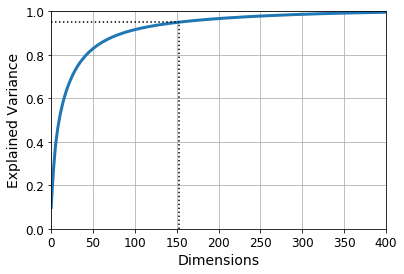

In [31]:
plt.axis([0, 400, 0, 1])
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([dim, dim], [0, 0.95], "k:")
plt.plot([0, dim], [0.95, 0.95], "k:")
plt.grid(True)

Проверим на каком-нибудь классификаторе:

1) Обучим классификатор на полном наборе данных (без применения PCA)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train, y_train)

y_pred = forest.predict(x_test)
score = accuracy_score(y_test, y_pred)
print("accuracy of full dataset dimentional:", score)

accuracy of full dataset dimentional: 0.968


2) Применим алгоритм PCA (обученный ранее сокращающий размерность с 784 до 154) и посмотрим сильно ли упадет точность

In [33]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(pca.transform(x_train), y_train)

y_pred = forest.predict(pca.transform(x_test))
score = accuracy_score(y_test, y_pred)
print("accuracy with 154 dataset dimentionality:", score)

accuracy with 154 dataset dimentionality: 0.9454285714285714


3) Аналогично пункту 2, но снизим размерность до 100

In [34]:
pca = PCA(n_components=100)
pca.fit(x_train)

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(pca.transform(x_train), y_train)

y_pred = forest.predict(pca.transform(x_test))
score = accuracy_score(y_test, y_pred)
print("accuracy with 100 dataset dimentionality:", score)

accuracy with 100 dataset dimentionality: 0.9476571428571429


4) Аналогично пункту 2, но снизим размерность до 60

In [36]:
pca = PCA(n_components=60)
pca.fit(x_train)

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(pca.transform(x_train), y_train)

y_pred = forest.predict(pca.transform(x_test))
score = accuracy_score(y_test, y_pred)
print("accuracy with 60 dataset dimentionality:", score)

accuracy with 60 dataset dimentionality: 0.9528571428571428


В целом падение точность незначительно. Возможно для ряда задач оно будет приемлемо

### PCA для сжатия даных

In [78]:
pca = PCA(n_components=0.95)
x_reduced   = pca.fit_transform(x_train)
x_recovered = pca.inverse_transform(x_reduced)

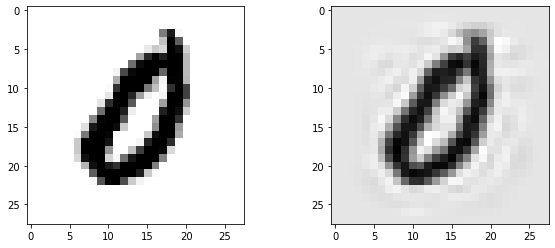

In [79]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
img = x_train[0].reshape(28,28)
plt.imshow(img, cmap = mpl.cm.binary, interpolation="nearest")

ax2 = plt.subplot(122)
img = x_recovered[0].reshape(28,28)
plt.imshow(img, cmap = mpl.cm.binary, interpolation="nearest")

plt.show()

reconstruction error

In [82]:
error = mean_squared_error(x_recovered, x_train)
print("Reconstruction error:", error)

Reconstruction error: 217.17071646959278


### Randomized PCA

In [86]:
import time

start_time = time.time()
rnd_pca = PCA(n_components=100, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(x_train)
print("Randomized PCA time:", time.time() - start_time)

start_time = time.time()
pca = PCA(n_components=100, svd_solver="full")
X_reduced = pca.fit_transform(x_train)
print("Common PCA time:", time.time() - start_time)

Randomized PCA time: 12.923720598220825
Common PCA time: 30.051116943359375


### Incremental PCA

In [88]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100 #кол-во экземпляров данных в пакете
inc_pca = IncrementalPCA(n_components=154)

for batch in np.array_split(x_train, n_batches):
    inc_pca.partial_fit(batch)
    x_reduced = inc_pca.transform(x_train)

# Kernal PCA

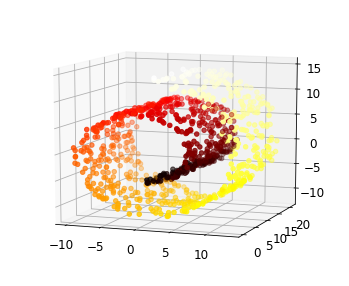

In [24]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(10, -70)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
plt.show()

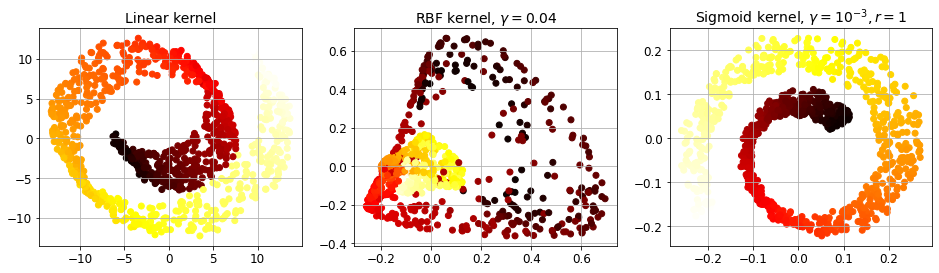

In [5]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

plt.figure(figsize=(16, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    x_ = pca.fit_transform(X)
    plt.subplot(subplot)
    plt.grid(True)
    plt.scatter(x_[:, 0], x_[:, 1], c=t, cmap=plt.cm.hot)
    plt.title(title, fontsize=14)    

**Подбираем гиперпараметры PCA**

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

y = t > 6.9

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

clf.fit(X, y)
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print("accuracy before using grid seach:", acc)

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X, y)

print("grid search best params:\n", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X)
acc = accuracy_score(y, y_pred)
print("accuracy using best params of grid seach:", acc)

accuracy before using grid seach: 0.711
grid search best params:
 {'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}
accuracy using best params of grid seach: 0.952


**Использование подхода оценки ошибки реконструкции данных**

In [81]:
pca = KernelPCA(n_components=2, gamma=0.4, kernel='rbf', 
                fit_inverse_transform=True)
x_reduced = pca.fit_transform(X)
x_pre_img = pca.inverse_transform(x_reduced)
mean_squared_error(x_pre_img, X)

41.562780441692304

In [139]:
pca = KernelPCA(n_components=2, fit_inverse_transform=True)
x_reduced = pca.fit_transform(X)
x_pre_img = pca.inverse_transform(x_reduced)
mean_squared_error(x_pre_img, X)

51.58463490232133

**Использование GreadSerch для поиска гиперпарамтеров kPCA**

In [138]:
from sklearn.metrics import mean_squared_error

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

def error_func(estimator, x, y=None):
    x_ = estimator.transform(x)
    x_pre_img = estimator.inverse_transform(x_)
    err = mean_squared_error(x, x_pre_img)
    print(err)
    return -err

kpca = KernelPCA(n_components=2, fit_inverse_transform=True, n_jobs=-1)
param_grid = [{
        "gamma": np.linspace(0.03, 0.05, 10),
        "kernel": ["rbf", "sigmoid"]
    }]
grid_search = GridSearchCV(kpca, param_grid, scoring=error_func, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X)
grid_search.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.0s finished


{'gamma': 0.05, 'kernel': 'sigmoid'}

In [141]:
x_reduced = grid_search.best_estimator_.transform(X)
x_pre_img = grid_search.best_etstimator_.inverse_transform(x_reduced)
mean_squared_error(x_pre_img, X)

21.242715414426858

In [143]:
reg = LogisticRegression(solver="lbfgs")
x_pca = grid_search.best_estimator_.transform(X)
reg.fit(x_pca, y)

y_pred = reg.predict(x_pca)
acc = accuracy_score(y, y_pred)
print("accuracy:", acc)

accuracy: 0.729


Видимо этот не тот случай, где поход использования метода подбора гиперпараметров с помощью fit_inverse_transform=True, а именно использования встроенного в класс KernelPCA предсказателя для последующего сравнения прообраза (pre-image) и исходных данных дает хорошие результаты для LogisticRegression и данных вида "швейцарский ролл".

# Locally Linear Embedding (LLE)

In [144]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [147]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

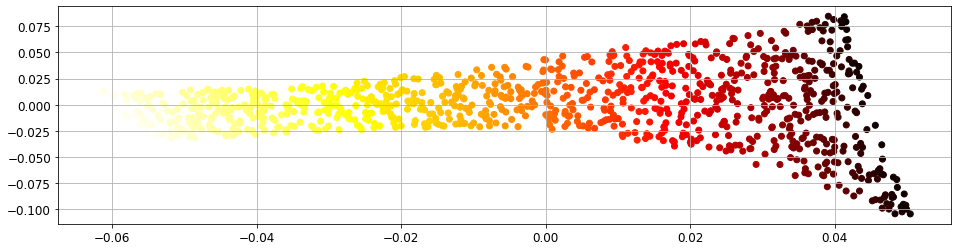

In [148]:
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

# Tasks

### task 1

What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

плосы: 
- позволяет ускорить процесс обучения
- визуализировать данные для последующего анализа
- выполнить компрессию данных

минусы:
- потеря информации;
- увеличение вычислительной нагрузки как в процессе обучения, так и для готового предсказателя - всегда дополнительно сокращать размерность входных данных

### task 2

What is the curse of dimensionality?

Данные с большой размерностью имеют риск находиться слишком далеко друг от друга. Это же касается новых объектов, для которых выполняется предсказание. Получается так, что модель плохо обобщена, поскольку расстояния между элементами в обучающем наборе очень велки (при очень большой размерности). Таким образом модели с высокой размерностью имеют тенденцию к переобучению. 

### task 3

Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

При использовании LinearPCA восстановлени данных к исходному состоянию происходит без проблем, нужно только умножить проецированные данные на полную матрицу векторлв PC. Естественно имеется некоторая потеря данных. При использовании kernel tricks (kPCA) все работает немного сложнее: kPCA использует встроенную модель регрессии, обученную на спроецированных данных в качестве обучающего набора и исходных данных в качестве target.Такая модель регрессии возвращает набор pre-image, который затем и сравнивается с исходным обучающим набором.

### task 4

Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

PCA может быть применено к любому набору данных. Важно то, что разные наборы данных могут иметь разные показатели сокращения размерности при сохранении вариативности. PSA избавляется от менее полезных размерности (вдоль которых данные имеют низкую вариативность или не имеют вообще). Однако некоторые данные могут плохо поддаваться сокращению размерности с помощью PCA, например, Швейцарский ролл в случае которого нужно развернуть его на гиперплоскость, а не искать вектора PC.

### task 5

Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

Это зависит от того, сколько данных в наборе данных, а точнее, насколько тесно данные расположены друг относительно друга.

That’s a trick question: it depends on the dataset. Let’s look at two extreme examples. First, suppose the dataset is composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around the 1,000 dimensions. In this case all 1,000 dimensions are required to preserve 95% of the variance. So the answer is, it depends on the dataset, and it could be any number between 1 and 1,000. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset’s intrinsic dimensionality.

### task 6

In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?

Randomized PCA - когда предпологается существенное сокращение размерности;
Incremental PCA - когда размер данных слишком большой, чтобы загрузить его в память (пакетное обучение PCA) или необходим режим online обучения.
regular PCA - default
kernel PCA - полезен на нелинейных данных

### task 7

How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

Используется GridSearch:

1) PCA упаковывается в pipeline, а следом идет предсказатель, например, LogisticRegression.

2) в GridSearch передается фукнция потерь, которая считает ошибку реконструкции данных.

Intuitively, a dimensionality reduction algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if you are using dimensionality reduction as a preprocessing step before another Machine Learning algorithm (e.g., a Random Forest classifier), then you can simply measure the performance
of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.

### task 8

Does it make any sense to chain two different dimensionality reduction algorithms?

Смысл есть, например, использовать PCA, чтобы избавиться от наименее полезных размерностей, а затем использовать более медленный алгоритм, например, LLE, чтобы спроецировать на гиперплоскость.

### task 9

Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?

In [49]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

x = mnist["data"]
y = mnist["target"].astype("int")

In [57]:
x_train, y_train = x[:60000],  y[:60000]
x_test , y_test  = x[-10000:], y[-10000:]

In [71]:
import time
from sklearn.ensemble import RandomForestClassifier

start = time.time()
forest = RandomForestClassifier(random_state=42, n_estimators=100)
forest.fit(x_train, y_train)
print("RandomForestClassifier has been learned for {:.4} sec.".
      format(time.time() - start))

RandomForestClassifier has been learned for 42.27 sec.


In [72]:
from sklearn.metrics import accuracy_score

y_pred = forest.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print("accuracy RandomForestClassifier on test set is {:.4}".format(acc))

accuracy RandomForestClassifier on test set is 97.05


In [73]:
start = time.time()
pca = PCA(n_components=0.95)
x_train_prejected = pca.fit_transform(x_train)
print("PCA has been learned for {:.4} sec.".format(time.time() - start))

PCA has been learned for 9.784 sec.


In [74]:
start = time.time()
forest = RandomForestClassifier(random_state=42, n_estimators=100)
forest.fit(x_train_prejected, y_train)
print("RandomForestClassifier has been learned for {:.4} sec.".
      format(time.time() - start))

RandomForestClassifier has been learned for 100.9 sec.


In [75]:
start = time.time()
x_test_projected = pca.transform(x_test)
print("Projection test set using PCA is taken {:.4} sec.".
      format(time.time() - start))

y_pred = forest.predict(x_test_projected)
acc = accuracy_score(y_test, y_pred) * 100
print("accuracy RandomForestClassifier on test set is {:.4}".format(acc))

Projection test set using PCA is taken 0.07345 sec.
accuracy RandomForestClassifier on test set is 94.81


Время обучения увеличилось с 42 до 101 сек (более чем в 2 раза). Причина в том, что после проецирования данные образовали, видимо, множество областей и необходимо было обучить более глубокое дерево, чтобы добиться соответствующей чистоты. Точность так же немного снизилась поскольку при сокращении размрености идет потеря вариативности данных.

**Проведем аналогичный анализ для классификатора LogisticRegression**

In [109]:
from sklearn.linear_model import LogisticRegression

log1 = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100, random_state=42, n_jobs=-1)
log2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100, random_state=42, n_jobs=-1)

In [110]:
start = time.time()
log1.fit(x_train, y_train)
print("Common takes {:.4} sec.".format(time.time() - start))

start = time.time()
log2.fit(x_train_prejected, y_train)
print("Reduced takes {:.4} sec.".format(time.time() - start))

Common takes 58.98 sec.
Reduced takes 15.89 sec.


In [115]:
y_pred = log1.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print("Common case accuracy {:.4}%.".format(acc))
      
y_pred = log2.predict(x_test_projected)
acc = accuracy_score(y_test, y_pred) * 100
print("Reduced case accuracy {:.4}%.".format(acc))

Common case accuracy 92.55%.
Reduced case accuracy 92.01%.


Данный алгоритм не ссильно теряет в производительности, но почти в 4е раза быстрее обучается

### task 10

Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations. 

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

x = mnist["data"]
y = mnist["target"].astype("int")

**visualization t-SNE**

На полном наборе данных не дождался, выполню для 10000

In [6]:
m = 10000
x_, y_ = x[:m], y[:m]

In [172]:
from sklearn.manifold import TSNE
import time

start = time.time()
tsne = TSNE(n_components=2)
x_reduced = tsne.fit_transform(x_)
print("took {:.4} sec.".format(time.time() - start))

took 210.7 sec.


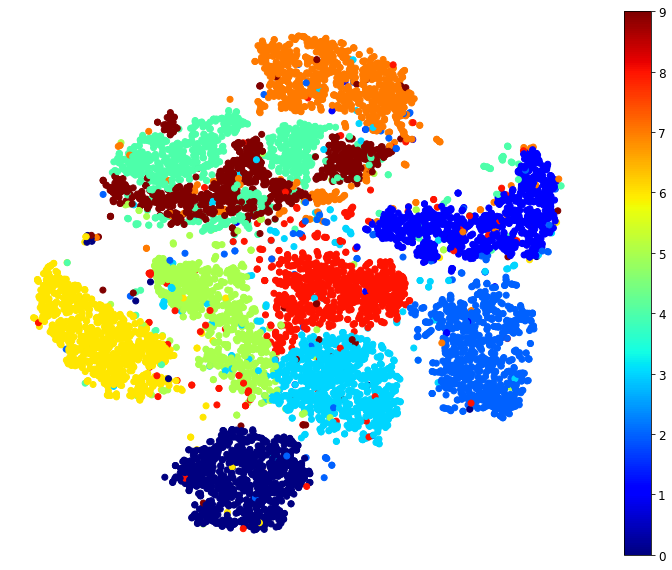

In [128]:
plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Сконцентируемся на цифрах, области которых пересекаются (2, 3, 5, 8)

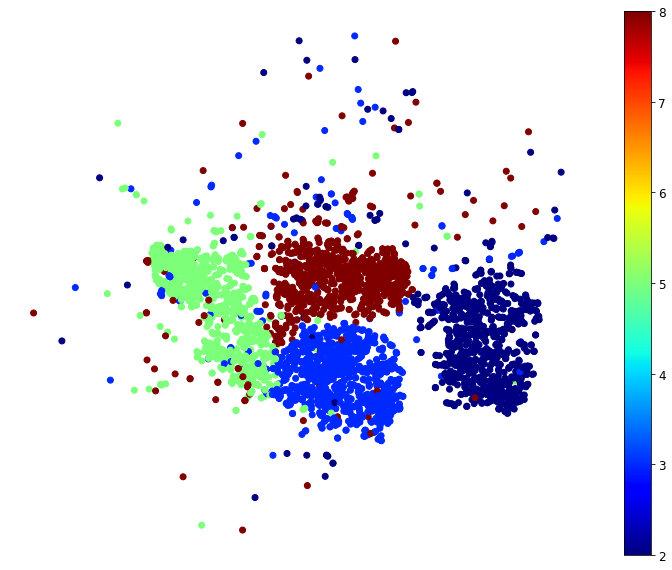

In [147]:
y_temp = (y_ == 2) | (y_ == 3) | (y_ == 5) | ( y_ == 8)
x_temp = x_reduced[y_temp]
y_temp = y_[y_temp]

plt.figure(figsize=(13,10))
plt.scatter(x_temp[:, 0], x_temp[:, 1], c=y_temp, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Попробуем применить тот же алгоритм к этим 4м цифрам

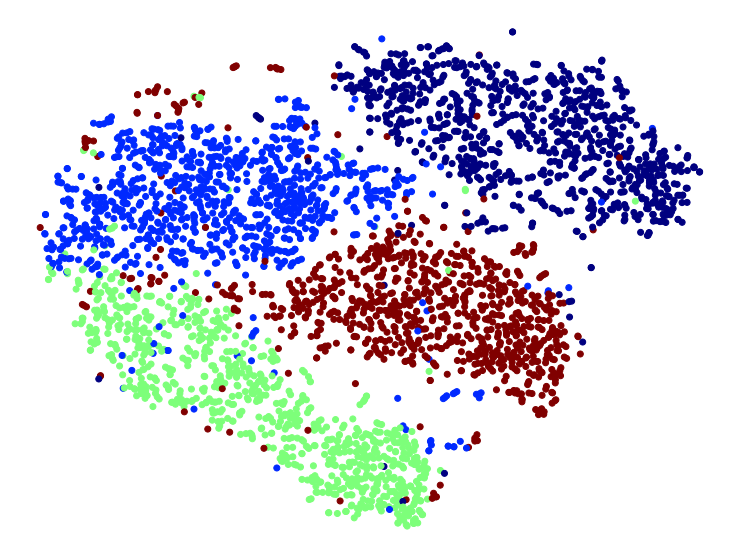

In [155]:
y_temp = (y_ == 2) | (y_ == 3) | (y_ == 5) | ( y_ == 8)
x_temp = x_[y_temp]
y_temp = y_[y_temp]

tsne = TSNE(n_components=2, n_jobs=-1)
x_reduced = tsne.fit_transform(x_temp)

plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_temp, cmap="jet")
plt.axis('off')
plt.show()

Теперь классы больше сконцентрированы в границах своих кластеров

**PCA**

took 0.2974 sec.


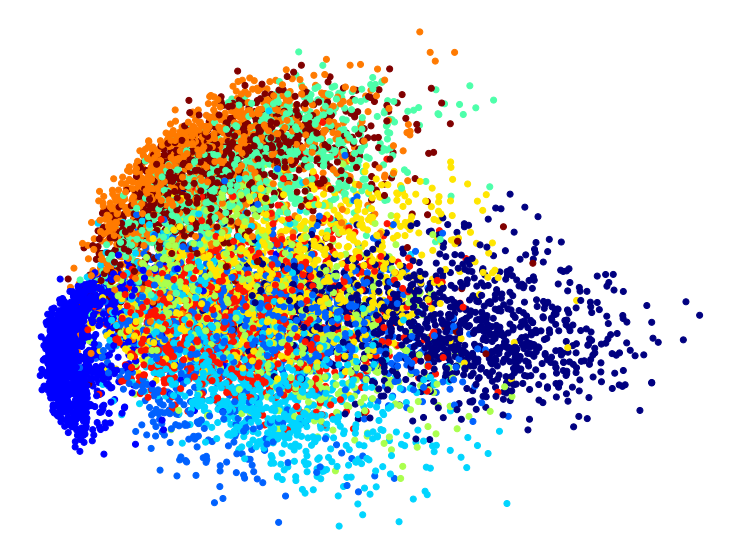

In [165]:
import time
from sklearn.decomposition import PCA 

start = time.time()
pca = PCA(n_components = 2, random_state=42)
x_reduced = pca.fit_transform(x_)
print("took {:.4} sec.".format(time.time() - start))

plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_, cmap="jet")
plt.axis('off')
plt.show()

the result isn't good

took 177.5 sec.


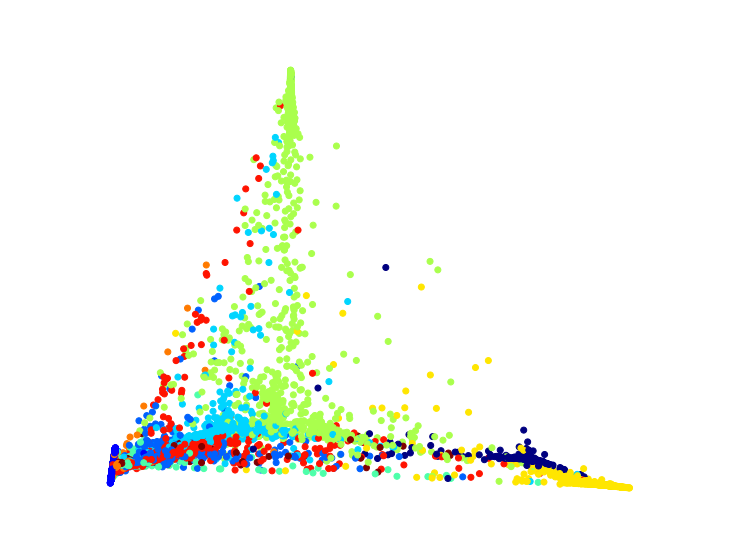

In [167]:
import time
from sklearn.manifold import LocallyLinearEmbedding  

start = time.time()
lle = LocallyLinearEmbedding(n_components = 2, random_state=42)
x_reduced = lle.fit_transform(x_)
print("took {:.4} sec.".format(time.time() - start))

plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_, cmap="jet")
plt.axis('off')
plt.show()

the result isn't good too

took 141.8 sec.


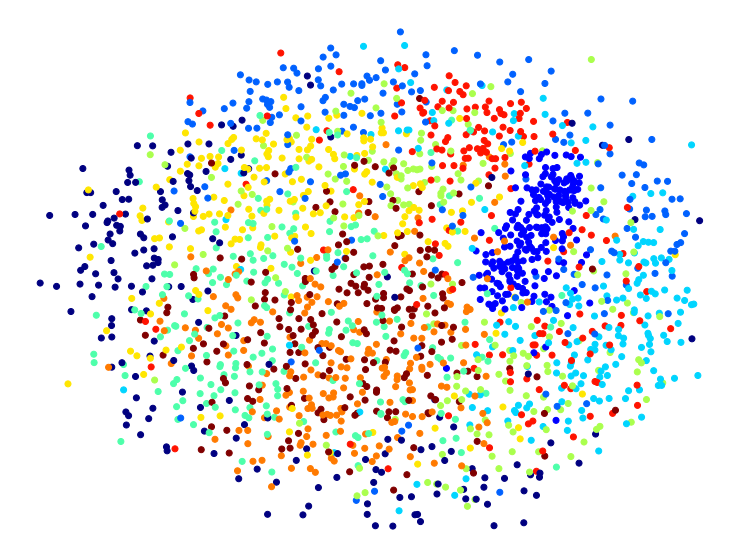

In [170]:
import time
from sklearn.manifold import MDS  

x__ = x_[:2000]
y__ = y_[:2000]

start = time.time()
mds = MDS(n_components = 2, random_state=42)
x_reduced = mds.fit_transform(x__)
print("took {:.4} sec.".format(time.time() - start))

plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y__, cmap="jet")
plt.axis('off')
plt.show()

Only 2000 elements in dataset due to alghorithms tend to allocate huge amount of memorry

**Let's combinate PCA and t-SNE**

took 145.5 sec.


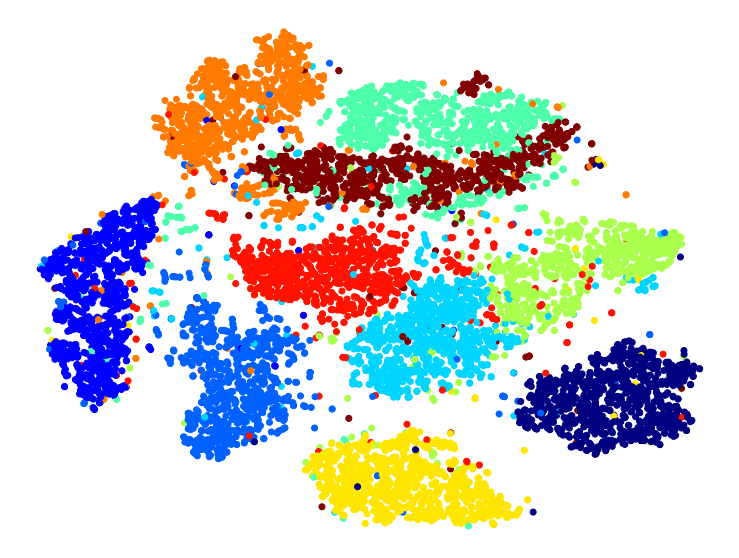

In [10]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])

start = time.time()
x_reduced = pca_tsne.fit_transform(x_)
print("took {:.4} sec.".format(time.time() - start))

plt.figure(figsize=(13,10))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y_, cmap="jet")
plt.axis('off')
plt.show()

Время работы алгоритма лучше, чем в случае использования только t-SNE (210.7 сек против 145.5 сек в данном случае, или на 30% быстрее). Визуализация данных показывает, что мы добились то же кластеризации (не хуже) чем в случае использования только t-SNE.